True events:
loc=70.000	t0=5.000
loc=30.000	t0=25.000


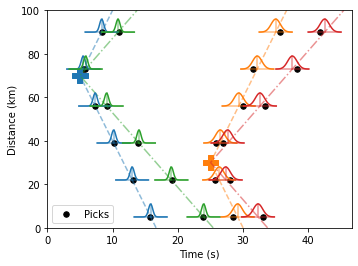

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import os

from numpy.ma.core import make_mask
from gmma import mixture
from collections import defaultdict
import time

figure_dir = "figures"
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)
np.random.seed(1)

#################### Data ##############################
## network setting
use_amplitude = False
vp = 6.0
vs = vp/1.75
num_event = 2
num_station = 6
xlim = [0, 100]
station_loc = np.linspace(xlim[0]+5.0, xlim[1]-10.0, num_station)[:, np.newaxis] + \
              np.random.uniform(low=-0, high=0, size=(num_station,1))
event_loc = np.linspace(xlim[0]+30.0, xlim[1]-30.0, num_event)[:, np.newaxis] + \
            np.random.uniform(low=-0, high=0, size=(num_event,1))
np.random.shuffle(event_loc)
event_t0 = np.linspace(5, (xlim[1]-xlim[0])/vp*1.5, num_event)
# np.random.shuffle(event_t0)
# event_mag = np.linspace(2, 5, num_event)
event_mag = np.logspace(np.log10(2.7), np.log10(2.7), num_event)
np.random.shuffle(event_mag)
print("True events:")
for i in range(num_event):
    if use_amplitude:
        print(f"loc={event_loc[i,0]:.3f}\tt0={event_t0[i]:.3f}\tmag={event_mag[i]:.3f}")
    else:
        print(f"loc={event_loc[i,0]:.3f}\tt0={event_t0[i]:.3f}")


np.random.seed(2)
phase_event_idx = []
phase_time = []
phase_amp = []
phase_type = []
phase_loc = []
c0, c1, c2, c3 = 1.08, 0.93, -0.015, -1.68
# phase_time_err = 0.5
# phase_amp_err = 0.5
phase_fp_rate = 0.0
for i in range(num_event):
    if i == 0:
        phase_time_err = 0.1
        phase_amp_err = 0.1
    else:
        phase_time_err = 0.7
        phase_amp_err = 0.7
    loc = event_loc[i]
    t0 = event_t0[i]
    mag = event_mag[i]
    dist = np.abs(loc - station_loc)
    tp = t0 + dist / vp 
    ts = t0 + dist / vs 
    logA = c0 + c1*(mag-3.5) + c3*np.log10(dist)
    # tp_err = np.random.uniform(low=-phase_time_err, high=phase_time_err, size=num_station)
    # ts_err = np.random.uniform(low=-phase_time_err, high=phase_time_err, size=num_station)
    tp_err = np.random.choice([-phase_time_err, phase_time_err], size=num_station)
    ts_err = np.random.choice([-phase_time_err, phase_time_err], size=num_station)
    logA_p_err = np.random.uniform(low=-phase_amp_err, high=phase_amp_err, size=num_station)
    logA_s_err = np.random.uniform(low=-phase_amp_err, high=phase_amp_err, size=num_station)
    for j in range(num_station):
        if logA[j] > -4:
            if np.random.rand() <= 1.0:
                phase_time.append(tp[j] + tp_err[j]) #p
                phase_amp.append(logA[j] + logA_p_err[j])
                phase_type.append("p")
                phase_loc.append(station_loc[j])
                phase_event_idx.append(i)
            if np.random.rand() <= 1.0:
                phase_time.append(ts[j] + ts_err[j]) #s
                phase_amp.append(logA[j] + + logA_s_err[j])
                phase_type.append("s")
                phase_loc.append(station_loc[j])
                phase_event_idx.append(i)

np.random.seed(1)
min_phase_time, max_phase_time = min(phase_time), max(phase_time) 
min_phase_amp, max_phase_amp = min(phase_amp), max(phase_amp) 
for i in range(int(len(phase_time) * phase_fp_rate)):
    phase_time.append(np.random.uniform(min_phase_time, max_phase_time)) #s
    phase_amp.append(np.random.uniform(min_phase_amp, max_phase_amp))
    phase_type.append(np.random.choice(["p", "s"]))
    phase_loc.append(station_loc[np.random.randint(num_station)])
    phase_event_idx.append(num_event)

phase_time = np.array(phase_time)
phase_amp = np.array(phase_amp)
phase_loc = np.array(phase_loc)
phase_event_idx = np.array(phase_event_idx)

plt.figure()
plt.gcf().set_size_inches(plt.gcf().get_size_inches() * np.array([2,1]))
plt.subplot(121)
if use_amplitude:
    plt.scatter(phase_time[phase_event_idx!=num_event], phase_loc[phase_event_idx!=num_event], \
                s=5**np.array(phase_amp[phase_event_idx!=num_event])*3000, \
                color=[f"C{x}"for x in phase_event_idx[phase_event_idx!=num_event]],  marker="o", facecolors='none')
    plt.scatter(phase_time[phase_event_idx==num_event], phase_loc[phase_event_idx==num_event], \
                s=5**np.array(phase_amp[phase_event_idx==num_event])*3000, \
                color="gray",  marker="o", alpha=0.5)
else:
    plt.scatter(phase_time[phase_event_idx!=num_event], phase_loc[phase_event_idx!=num_event], \
                s=30, \
                # color=[f"C{x}"for x in phase_event_idx[phase_event_idx!=num_event]],  marker="o", facecolors='none')
                color="k",  marker="o", label="Picks")
    plt.scatter(phase_time[phase_event_idx==num_event], phase_loc[phase_event_idx==num_event], \
                s=30, \
                color="gray",  marker="o", alpha=0.5)

# plt.scatter(phase_time, phase_loc, s=5**np.array(phase_amp)*3000, color=[f"C{x}" if x!= num_event else "gray" for x in phase_event_idx],  marker="o", facecolors=['none' if x!= num_event else "gray" for x in phase_event_idx])
# plt.scatter(phase_time, phase_loc, s=5**np.array(phase_amp)*3000, color=[f"C{x}" if x!= num_event else "gray" for x in phase_event_idx],  marker="o", facecolors='none')
plt.scatter(event_t0, event_loc, s=5**np.array(event_mag)*3, color=[f"C{x}" for x in range(len(event_mag))], marker="P")#, label="Earthquake")

# for i in range(len(event_mag)):
#     plt.scatter(event_t0[i], event_loc[i], s=5**np.array(event_mag[i])*3, color=f"C{i}", marker="P", label=f"True event #{i}")
plt.xlim(left=0)
plt.ylim(xlim)
plt.ylabel("Distance (km)")
plt.xlabel("Time (s)")
ylim_ = plt.ylim()
xlim_ = plt.xlim()
plt.xlim([0, xlim_[1]+3])
# plt.legend(fontsize="x-small")
# plt.show()

y = np.linspace(ylim_[0], ylim_[1], 1000)
for i in range(len(event_loc)):
    plt.plot(np.abs((y-event_loc[i])/vp) + event_t0[i], y, c=f"C{i}", linestyle="--", alpha=0.5)
    plt.plot(np.abs((y-event_loc[i])/vs) + event_t0[i], y, c=f"C{i+len(event_loc)}", linestyle="-.", alpha=0.5)

sigma = [0.2, 1.0]
for i in range(len(event_loc)):
    x_gauss = np.linspace(-2.5, 2.5, 40)
    y_gauss = 6 * np.exp(-x_gauss**2/sigma[i])
    for j in range(len(station_loc)):
        plt.plot(x_gauss+np.abs((station_loc[j]-event_loc[i])/vp) + event_t0[i], y_gauss+station_loc[j], c=f"C{i}")
        plt.plot(x_gauss+np.abs((station_loc[j]-event_loc[i])/vp) + event_t0[i], y_gauss*0+station_loc[j], c=f"C{i}", alpha=0.5)
        plt.plot(np.array([0,0])+np.abs((station_loc[j]-event_loc[i])/vp) + event_t0[i], np.array([0,6])+station_loc[j], c=f"C{i}", alpha=0.5)
        plt.plot(x_gauss+np.abs((station_loc[j]-event_loc[i])/vs) + event_t0[i], y_gauss+station_loc[j], c=f"C{i+len(event_loc)}")
        plt.plot(x_gauss+np.abs((station_loc[j]-event_loc[i])/vs) + event_t0[i], y_gauss*0+station_loc[j], c=f"C{i+len(event_loc)}", alpha=0.5)
        plt.plot(np.array([0,0])+np.abs((station_loc[j]-event_loc[i])/vs) + event_t0[i], np.array([0,6])+station_loc[j], c=f"C{i+len(event_loc)}", alpha=0.5)



plt.legend()
plt.savefig(os.path.join(figure_dir, f"diagram_gmma.png"), bbox_inches="tight", dpi=300)
plt.savefig(os.path.join(figure_dir, f"diagram_gmma.pdf"), bbox_inches="tight")

In [2]:
figure_dir

'figures'